In [1]:
import torch.nn.functional as F
from utilities3 import *
from timeit import default_timer

import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
from data_loader_SSH import load_test_data, load_test_data_DTAS
from data_loader_SSH import load_train_data, load_train_data_DTAS
from count_trainable_params import count_parameters
import hdf5storage

2.0.1+cu117
2.0.1+cu117


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Config

In [17]:
datastore_filepath = '/data/NASA_DTAS_datastore/'
filename_dict = {
    'u10' : 'U10_large_domain/U10deg_025',
    'v10' : 'V10_large_domain/V10deg_025',
    't2m' : 'T2m_large_domain/T2mdeg_025',
    'mslhf' : 'MSLHF_large_domain/MSLHFdeg_025',
    'msshf' : 'MSSHF_large_domain/MSSHFdeg_025'
}

def get_testdata(yr, vlist, lead):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_test_data_DTAS(DS, lead, v)
        else:
            input_torch, label_torch, _ = load_test_data_DTAS(DS, lead, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

def get_traindata(yr, vlist, lead, trainN):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        # print("dMsg:", i, v)
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_train_data_DTAS(DS, lead, trainN, v)
        else:
            input_torch, label_torch, _ = load_train_data_DTAS(DS, lead, trainN, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

        
    

In [5]:
path_outputs = '/data/NASA_DTAS_datastore/ML_models/experimental/'

# FF=nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_0252019.nc')

In [6]:
lead = 1
varlist = ['mslhf', 'msshf']

# psi_test_input_Tr_torch, psi_test_label_Tr_torch,_  = load_test_data(FF,lead)
psi_test_input_Tr_torch, psi_test_label_Tr_torch,_ = get_testdata(2019, varlist, lead)

In [7]:
print(psi_test_input_Tr_torch.shape)
print(psi_test_label_Tr_torch.shape)

torch.Size([8759, 2, 65, 121])
torch.Size([8759, 2, 65, 121])


In [8]:
# M_test_level1=torch.mean((psi_test_input_Tr_torch.flatten()))
# STD_test_level1=torch.std((psi_test_input_Tr_torch.flatten()))
M_test_level1 = torch.mean(psi_test_input_Tr_torch, (0,2,3))
STD_test_level1 = torch.std(psi_test_input_Tr_torch, (0,2,3))

In [9]:
psi_test_input_Tr_torch_norm_level1 = torch.zeros_like(psi_test_input_Tr_torch)
psi_test_label_Tr_torch_norm_level1 = torch.zeros_like(psi_test_label_Tr_torch)

for i in range(len(varlist)):
    psi_test_input_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_input_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])
    psi_test_label_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_label_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])
    
    
# psi_test_input_Tr_torch_norm_level1 = ((psi_test_input_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)
# psi_test_label_Tr_torch_norm_level1 = ((psi_test_label_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)

print('mean value',M_test_level1)
print('std value',STD_test_level1)

mean value tensor([-133.3054,  -27.5596])
std value tensor([130.9617,  60.5951])


In [10]:
def regular_loss(output, target):

 loss = torch.mean((output-target)**2)
 return loss

def ocean_loss(output, target, ocean_grid):

 loss = (torch.sum((output-target)**2))/ocean_grid
 return loss

def spectral_loss(output, target,wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid

# out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
# target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)

 out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=1)),dim=2)
 target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=1)),dim=2)


# loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))

 loss = ((1-lamda_reg)*loss1 + lamda_reg**loss2_ydir)

 return loss

def RK4step(net,input_batch):
 output_1 = net(input_batch.cuda())
 output_2= net(input_batch.cuda()+0.5*output_1)
 output_3 = net(input_batch.cuda()+0.5*output_2)
 output_4 = net(input_batch.cuda()+output_3)

 return input_batch.cuda() + (output_1+2*output_2+2*output_3+output_4)/6


def Eulerstep(net,input_batch):
 output_1 = net(input_batch.cuda())
 return input_batch.cuda() + (output_1)


def directstep(net,input_batch):
  output_1 = net(input_batch.cuda())
  return output_1

def PECstep(net,input_batch):
 output_1 = net(input_batch.cuda()) + input_batch.cuda()
 return input_batch.cuda() + 0.5*(net(input_batch.cuda())+net(output_1))

In [11]:
psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()
Nlat = np.size(psi_test_label_Tr,2)
Nlon = np.size(psi_test_label_Tr,3)

# batch_size = 10 
num_epochs = 40
num_samples = 2

lamda_reg =0.1
wavenum_init=0
wavenum_init_ydir=0



modes = 16
width = 20

batch_size = 40
learning_rate = 0.001
epochs = 40

## training and evaluation

In [22]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(4, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [26]:
net = FNO2d(modes, modes, width).cuda()
print(count_params(net))
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=1e-4)


1645301


In [27]:
psi_test_input_Tr_torch_norm_level1[0:num_samples,:,0:Nlat,0:Nlon].shape

torch.Size([2, 2, 65, 121])

In [28]:
for epoch in range(0, 1):  # loop over the dataset multiple times

 running_loss = 0.0


 for k in range(1992,1993):
  print('File index',k)

#   G = nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_025'+str(k)+'.nc')
  trainN=8500
#   psi_train_input_Tr_torch, psi_train_label_Tr_torch, ocean_grid  = load_train_data(G,lead,trainN)
  psi_train_input_Tr_torch, psi_train_label_Tr_torch, ocean_grid = get_traindata(k, varlist, lead, trainN)
  print('Ocean grid',ocean_grid)
  
  # M_train_level1=torch.mean((psi_train_input_Tr_torch.flatten()))
  # STD_train_level1=torch.std((psi_train_input_Tr_torch.flatten()))
  M_train_level1 = torch.mean(psi_train_input_Tr_torch, (0,2,3))
  STD_train_level1 = torch.std(psi_train_input_Tr_torch, (0,2,3))

#  M_train_level1=0
#  STD_train_level1=1

  # psi_train_input_Tr_torch_norm_level1 = ((psi_train_input_Tr_torch[:,0,None,:,:]-M_train_level1)/STD_train_level1)
  # psi_train_label_Tr_torch_norm_level1 = ((psi_train_label_Tr_torch[:,0,None,:,:]-M_train_level1)/STD_train_level1)
  
  psi_train_input_Tr_torch_norm_level1 = torch.zeros_like(psi_train_input_Tr_torch)
  psi_train_label_Tr_torch_norm_level1 = torch.zeros_like(psi_train_label_Tr_torch)

  for i in range(len(varlist)):
      psi_train_input_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_train_input_Tr_torch[:,i,None,:,:]-M_train_level1[i])/STD_train_level1[i])
      psi_train_label_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_train_label_Tr_torch[:,i,None,:,:]-M_train_level1[i])/STD_train_level1[i])


  for step in range(0,trainN-batch_size,batch_size):
      # get the inputs; data is a list of [inputs, labels]
      indices = np.random.permutation(np.arange(start=step, stop=step+batch_size))
      input_batch, label_batch = psi_train_input_Tr_torch_norm_level1[indices,:,:,:], psi_train_label_Tr_torch_norm_level1[indices,:,:,:]

      input_batch = input_batch.permute(0,2,3,1)
      label_batch = label_batch.permute(0,2,3,1)

      # print('shape of input', input_batch.shape)
      # print('shape of output', label_batch.shape)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      # output= net(input_batch.cuda())
      output = PECstep(net,input_batch.cuda())
      # output = Eulerstep(net,input_batch.cuda())
      # print('shape of FNO2D output',output.shape)
      #        loss = regular_loss(output, label_batch_crop.cuda())
      # print statistics
      loss = spectral_loss(output, label_batch.cuda(),wavenum_init,wavenum_init_ydir,lamda_reg,(torch.tensor(ocean_grid)).cuda())
#        loss = ocean_loss(output, label_batch_crop.cuda(),(torch.tensor(ocean_grid)).cuda())
      loss.backward()
      optimizer.step()
      output_val = PECstep(net,(psi_test_input_Tr_torch_norm_level1[0:num_samples,:,0:Nlat,0:Nlon].reshape([num_samples,2,Nlat,Nlon])).permute(0,2,3,1))
      # output_val = Eulerstep(net,(psi_test_input_Tr_torch_norm_level1[0:num_samples,:,0:Nlat,0:Nlon].reshape([num_samples,2,Nlat,Nlon])).permute(0,2,3,1))
      
      
      val_loss = spectral_loss(output_val, (psi_test_label_Tr_torch_norm_level1[0:num_samples,:,0:Nlat,0:Nlon].reshape([num_samples,2,Nlat,Nlon])).permute(0,2,3,1).cuda(),wavenum_init,wavenum_init_ydir,lamda_reg,(torch.tensor(ocean_grid)).cuda())
#        val_loss = ocean_loss(output_val, psi_test_label_Tr_torch[0:num_samples,:,0:Nlat-2,0:Nlon-1].reshape([num_samples,1,Nlat-2,Nlon-1]).cuda(),(torch.tensor(ocean_grid)).cuda())
      if step % 100 == 0:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, step + 1, loss))
          print('[%d, %5d] val_loss: %.3f' %
                (epoch + 1, step + 1, val_loss))
          running_loss = 0.0
print('Finished Training')

File index 1992
Ocean grid 7865
[1,     1] loss: 1.866
[1,     1] val_loss: 0.710
[1,   201] loss: 2.471
[1,   201] val_loss: 0.819
[1,   401] loss: 6.887
[1,   401] val_loss: 0.809
[1,   601] loss: 4.730
[1,   601] val_loss: 0.765
[1,   801] loss: 2.438
[1,   801] val_loss: 0.794
[1,  1001] loss: 3.924
[1,  1001] val_loss: 0.734
[1,  1201] loss: 1.604
[1,  1201] val_loss: 0.817
[1,  1401] loss: 3.071
[1,  1401] val_loss: 0.780
[1,  1601] loss: 2.005
[1,  1601] val_loss: 0.797
[1,  1801] loss: 4.502
[1,  1801] val_loss: 0.764
[1,  2001] loss: 3.400
[1,  2001] val_loss: 0.763
[1,  2201] loss: 1.819
[1,  2201] val_loss: 0.797
[1,  2401] loss: 1.915
[1,  2401] val_loss: 0.796
[1,  2601] loss: 2.133
[1,  2601] val_loss: 0.794
[1,  2801] loss: 1.827
[1,  2801] val_loss: 0.829
[1,  3001] loss: 1.561
[1,  3001] val_loss: 0.825
[1,  3201] loss: 1.370
[1,  3201] val_loss: 0.810
[1,  3401] loss: 1.691
[1,  3401] val_loss: 0.814
[1,  3601] loss: 1.501
[1,  3601] val_loss: 0.822
[1,  3801] loss: 1

In [18]:
torch.save(net.state_dict(), path_outputs+'./dummy_BNN_FNO2D_PECstep_MSSHF_ocean_spectral_loss_modes_'+str(modes)+'_wavenum'+str(wavenum_init)+'lead'+str(lead)+'.pt')

print('BNN Model Saved')

BNN Model Saved


In [23]:
print(psi_test_input_Tr_torch_norm_level1.shape)
print(psi_test_label_Tr_torch_norm_level1.shape)

torch.Size([8759, 1, 65, 121])
torch.Size([8759, 1, 65, 121])


In [30]:
test_input_batch = psi_test_input_Tr_torch_norm_level1[10:11,:,:,:].permute(0,2,3,1)
test_label_batch = psi_test_label_Tr_torch_norm_level1[10:11,:,:,:].permute(0,2,3,1)

In [49]:
test_label_batch.shape

torch.Size([1, 65, 121, 1])

In [45]:
optimizer.zero_grad()
test_output = Eulerstep(net,test_input_batch.cuda())
loss = regular_loss(test_output, test_label_batch.cuda())
print(loss)
loss.backward()



tensor(0.0684, device='cuda:0', grad_fn=<MeanBackward0>)


In [46]:
optimizer.step()

RuntimeError: The size of tensor a (2) must match the size of tensor b (16) at non-singleton dimension 4

In [44]:
test_output.shape

torch.Size([1, 65, 121, 1])

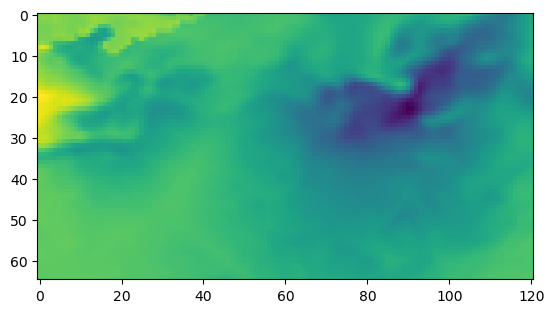

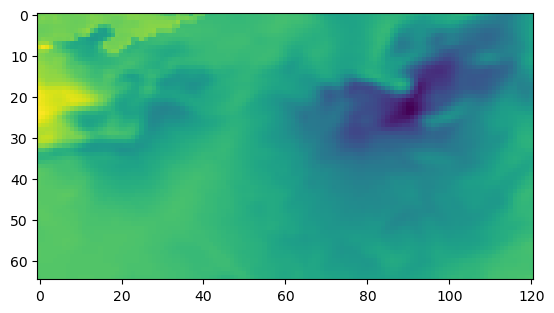

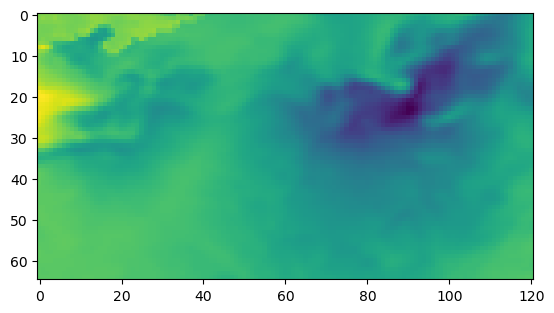

In [39]:
plt.imshow(test_input_batch[0,:,:,0])
plt.show()
plt.imshow(test_label_batch[0,:,:,0])
plt.show()
plt.imshow(test_output.detach().cpu().numpy()[0,:,:,0])
plt.show()


torch.Size([65, 121])